In [1]:
# Import dati dalla prof
from scipy.io import loadmat
import numpy as np
import scipy.linalg as spl
import RisolviSis as RS
import matplotlib.pyplot as plt
dati = loadmat('Approx_C.mat')
A = dati["x"]
B = dati["y"]


### Formula di Lagrange

In [3]:
# Date le coppie (x_i, y_i) che rappresentano dei nodi di interpolazione,
# si definiscono x i nodi e y le valutazioni di un fenoemeno in quei nodi.
# Determinare un polinomio di interpolazione significa innanzitutto determinarne
# i suoi coefficienti, tali che soddisfino la condizione di interpolazione 
# P(x_i) = y_i.
# Successivamente a ciò si potranno determinare dati che stanno sia dentro 
# (interpolazione) che fuori (estrapolazione) dal range dei dati forniti.
# Il polinomio è facilmente rappresentabile come una matrice di Vandermonde,
# che ricordiamo essere molto mal condizionata e quindi soggetta a grossi 
# errori, se sottoposta anche a minime perturbazioni, a cui è associato un 
# vettore colonna della valutazione del fenomeno nei nodi.
# In questo caso il sistema lineare ammette una ed una sola soluzione se e 
# solo se la matrice è quadrata ed il rango è massimo. La matrice di Vandermonde 
# ha sempre rango massimo se tutti gli x_i sono distinti, conseguentemente il 
# polinomio interpolatore esiste sempre ed è unico.
# Al crescere del numero dei punti di interpolazione, e quindi del grado del 
# polinomio interpolatore non si ha la convergenza del polinomio interpolatore 
# alla funzione che ha generato i dati: ha al centro dell’intervallo una buona 
# approssimazione e delle fitte oscillazioni agli estremi.
def plagr(x_nodi, k):
    """
    Restituisce i coefficienti del k-esimo pol di
    Lagrange associato ai punti del vettore xnodi
    """
    x_zeri = np.zeros_like(x_nodi)
    n = x_nodi.size
    if k == 0:
        x_zeri = x_nodi[1:n]
    else:
        x_zeri = np.append(x_nodi[0 : k], x_nodi[k + 1 : n])

    num = np.poly(x_zeri)
    den = np.polyval(num, x_nodi[k])

    # Il polinomio interpolatore è unico
    p = num / den

    return p


In [4]:
# Costruisce n+1 polinomi di Lagrange che rappresentano una base per lo spazio
# dei polinomi di grado <= n: ai coeffienti di questi polinomi corrispondono una
# matrice identità e il vettore soluzione.
def InterpL(x, f, xx):
    """
       %funzione che determina in un insieme di punti il valore del polinomio
       %interpolante ottenuto dalla formula di Lagrange.
       % DATI INPUT
       %  x  vettore con i nodi dell'interpolazione
       %  f  vettore con i valori dei nodi 
       %  xx vettore con i punti in cui si vuole calcolare il polinomio
       % DATI OUTPUT
       %  y vettore contenente i valori assunti dal polinomio interpolante
       %
    """
    n = x.size
    m = xx.size
    L = np.zeros((m, n))
    for k in range(n):
        p = plagr(x, k)
        # Il polinomio di Lagrange k-esimo valutato nei punti xx
        # La costante di Lebesgue risulta essere il coefficiente di amplificazione degli errori 
        # relativi sui dati e pertanto identifica il numero di condizionamento del problema 
        # di interpolazione polinomiale
        L[:, k] = np.polyval(p, xx)

    return np.dot(L, f)


### Errori con Chebichev

In [11]:
# L'errore risulta minimo se si scelgono gli x_i come zeri del polinomio di
# Chebichev: all’aumentare del numero dei punti di interpolazione si ha la
# convergenza del polinomio interpolatore alla funzione che ha generato di dati.
# La crescita dell'errore in questo caso é logaritmica anziché esponenziale.
def Cheb(a, b, n):
    t1 = (a + b) / 2
    t2 = (b - a) / 2
    diff = []
    x = np.zeros((n + 1 , ))

    for k in range(n + 1):
        x[k] = t1 + t2 * np.cos(((2 * k + 1) / (2 * (n + 1)) * np.pi))
    return x


Per $n = 5, 10, 15, 20$ fornire un'approssimazione della costante di Lebesgue
scegliendo $x_1, x_2, ..., x_{n+1}$ equispaziati in $[-1, 1]$ oppure coincidenti con
i nodi di Chebyshev $x_i = \cos \left(\frac{(2i-1)\pi}{2(n + 1)}  \right)$, $i =1, ..., n + 1$.

Costante di Lebesgue con nodi equispaziati al variare di n: 
  [[3.10493825e+00]
 [2.98943063e+01]
 [5.08711306e+02]
 [1.07596490e+04]]
Costante di Lebesgue con nodi di Chebyshev al variare di n: 
 [[2.10439768]
 [2.48943038]
 [2.72777794]
 [2.9008249 ]]


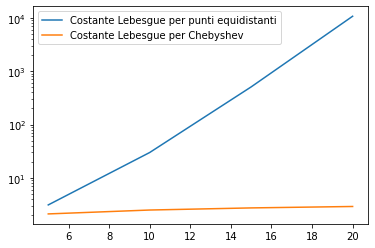

In [12]:
xx = np.linspace(-1, 1, 200)
LLe = np.zeros((4, 1))
LLc = np.zeros((4, 1))

i = 0
for n in range(5, 25, 5):

    # nodi equispaziati
    xe = np.linspace(-1, 1, n + 1)

    # nodi di Chebyshev
    xc = Cheb(-1, 1, n)

    Le = np.zeros((200, 1))
    Lc = np.zeros((200, 1))

    for l in range(n + 1):
        pe = plagr(xe, l)
        Le = Le + np.abs(np.polyval(pe, xx))
        pc = plagr(xc, l)
        Lc = Lc + np.abs(np.polyval(pc, xx))

    LLe[i] = np.max(Le)
    LLc[i] = np.max(Lc)
    i += 1

print('Costante di Lebesgue con nodi equispaziati al variare di n: \n ', LLe)
plt.semilogy(range(5, 25, 5), LLe, range(5, 25, 5), LLc)
plt.legend(["Costante Lebesgue per punti equidistanti",
           "Costante Lebesgue per Chebyshev"])

print('Costante di Lebesgue con nodi di Chebyshev al variare di n: \n', LLc)
plt.show()


### Interpolare dati in input

Rango  4 Condizionamento  138.0410649852687


NameError: name 'QRLS' is not defined

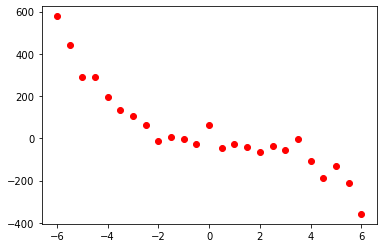

In [5]:
# Presi dei dati
dati = loadmat('Approx_C.mat')
x = dati["x"]
y = dati["y"]

# Rappresento i dati che devono essere interpolati
m = x.shape[0]
x = x.reshape(m, )
y = y.reshape(m, )
plt.plot(x, y, 'ro')

# Visualizzando il trend dei dati e osservo che hanno un andamento di un polinomio cubico
# Costruisco la matrice di Vandermonde per la rappresentazione del polinomio interpolatore.
n = 3
n1 = n + 1
A3 = np.vander(x, increasing=True)[:, :n1]
print('Rango ', np.linalg.matrix_rank(A3),
      'Condizionamento ', np.linalg.cond(A3))

# La matrice A è a rango massimo e mediamente mal condizionata,
# la matrice A.T @ A, avrà indice di condizionamento il quadrato
# dell'indice di condizionamento di A, per cui uso il metodo QR.
alphaqr, res = QRLS(A3, y)
print("residuo ", res)

# Creo il polinomio interpolatore.
xx = np.linspace(np.min(x), np.max(x), 200)
polQR = np.polyval(np.flip(alphaqr), xx)
plt.plot(xx, polQR)


### Interpolazione manuale

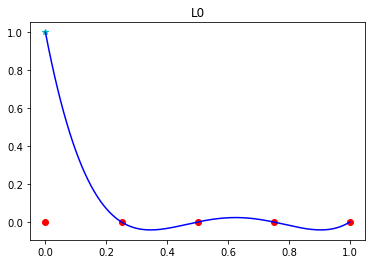

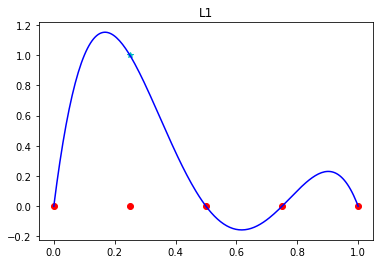

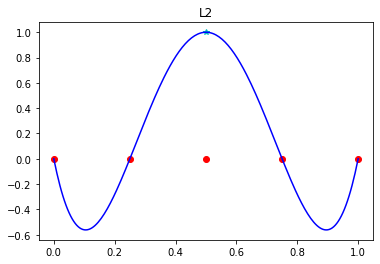

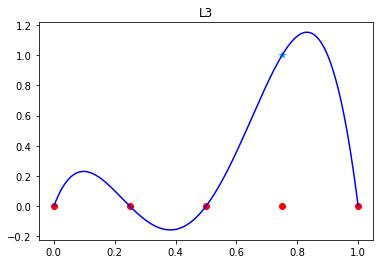

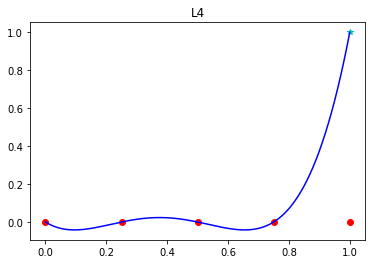

In [6]:
# Dato un set di nodi
xnodi = np.arange(0, 1.1, 1/4)
n = xnodi.size
# e uno sottospazio di essi da interpolare
xx = np.linspace(xnodi[0], xnodi[n - 1], 200)

# Creo il polinomio di lagrange per ciascun nodo
for k in range(n):
    p = plagr(xnodi, k)
    L = np.polyval(p, xx)
    # Grafico
    plt.plot(xnodi, np.zeros((n,)), 'ro')
    plt.plot(xnodi[k], 1, 'c*')
    plt.plot(xx, L, 'b-')
    plt.title('L' + str(k))
    plt.show()


### Interpolazione di funzioni

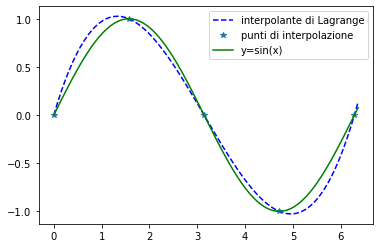

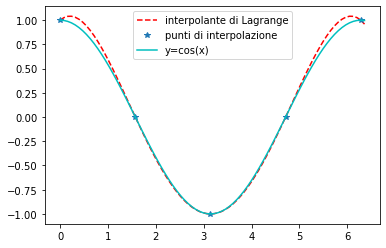

In [7]:
# Dato un set di punti di interpolazione, 0.1 serve per evitare
# che l'interpolazione esploda a causa delle produttorie, per
# valori da interpolare che sono troppo vicini a 0.
x = np.arange(0, 2 * np.pi + 0.1, np.pi / 2)
# Dati i punti di valutazione
xx = np.arange(0, 2 * np.pi + 0.1, np.pi / 40)

# Descrivo le singole funzioni e calcolo il polinomio
# interpolatore di Lagrange.
y1 = np.sin(x)
yy1 = InterpL(x, y1, xx)
y2 = np.cos(x)
yy2 = InterpL(x, y2, xx)

# Disegno
plt.plot(xx, yy1, 'b--', x, y1, '*', xx, np.sin(xx), 'g-')
plt.legend(['interpolante di Lagrange', 'punti di interpolazione', 'y=sin(x)'])
plt.show()

plt.plot(xx, yy2, 'r--', x, y2, '*', xx, np.cos(xx), 'c-')
plt.legend(['interpolante di Lagrange', 'punti di interpolazione', 'y=cos(x)'])
plt.show()


### Previsioni di temperatura

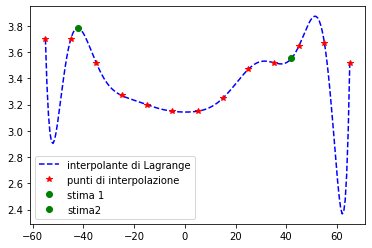

In [8]:
# Latitudini e temperature
L = np.array([-55, -45, -35, -25, -15, -5, 5, 15, 25, 35, 45, 55, 65])
T = np.array([3.7, 3.7, 3.52, 3.27, 3.2, 3.15, 3.15,
             3.25, 3.47, 3.52, 3.65, 3.67, 3.52])

# punti di valutazione per l'interpolante
xx = np.linspace(np.min(L), np.max(L), 200)
pol = InterpL(L, T, xx)

# Punti da stimare
pol42 = InterpL(L, T, np.array([42]))
pol_42 = InterpL(L, T, np.array([-42]))

plt.plot(xx, pol, 'b--', L, T, 'r*', 42, pol42, 'og', -42, pol_42, 'og')
plt.legend(['interpolante di Lagrange',
           'punti di interpolazione', 'stima 1', 'stima2'])
plt.show()


### Errori di interpolazione

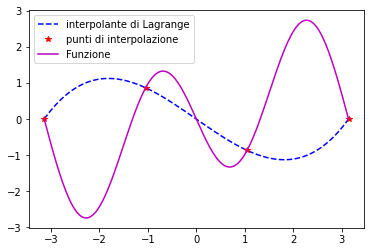

Norma infinito di r  3.7567509003273782


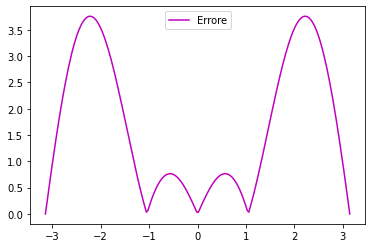

In [9]:
f = lambda x: np.sin(x) - 2 * np.sin(2 * x)
a = -np.pi
b = np.pi

# Gradi del polinomio
n = 3

# Nodi
x = np.linspace(a, b, n + 1)

# punti di valutazione per l'interpolante
xx = np.linspace(a, b, 200)

# Funzione e polinomio interpolatore
y = f(x)
pol = InterpL(x, y, xx)

# Disegno
plt.plot(xx, pol, 'b--', x, y, 'r*', xx, f(xx), 'm-')
plt.legend(['interpolante di Lagrange', 'punti di interpolazione', 'Funzione'])
plt.show()

r = np.abs(f(xx) - pol)
norm_inf_r = np.linalg.norm(r, np.inf)

print("Norma infinito di r ", norm_inf_r)
plt.plot(xx, r, 'm-')
plt.legend(['Errore'])
plt.show()


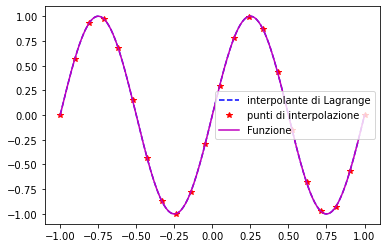

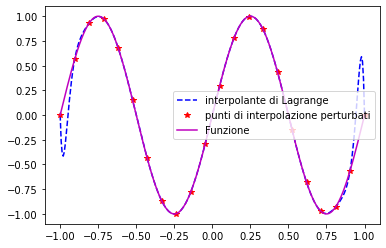

Errore relativo sui dati  0.00019422984317001685
Errore relativo sui risultati  0.7196598681463975


In [10]:
def f(x): return np.sin(2*np.pi*x)

# Nodi e funzione
x = np.linspace(-1, 1, 22)
y1 = f(x)
y2 = y1.copy()
y2 = y2 + (0.0002 * np.random.random(22, ))

# Punti di valutazione per l'interpolante
xx = np.linspace(-1, 1, 300)

# Polinomio interpolatore
pol1 = InterpL(x, y1, xx)
pol2 = InterpL(x, y2, xx)

# Disegno
plt.plot(xx, pol1, 'b--', x, y1, 'r*', xx, f(xx), 'm-')
plt.legend(['interpolante di Lagrange', 'punti di interpolazione', 'Funzione'])
plt.show()

plt.plot(xx, pol2, 'b--', x, y2, 'r*', xx, f(xx), 'm-')
plt.legend(['interpolante di Lagrange',
           'punti di interpolazione perturbati', 'Funzione'])
plt.show()

# errore relativo sui dati
errrel_dati = np.linalg.norm(y2-y1, np.inf) / np.linalg.norm(y1, np.inf)

# errore relativo sui risultati
errrel_risultati = np.linalg.norm(pol2-pol1, np.inf) / np.linalg.norm(pol1, np.inf)

# stoudt
print("Errore relativo sui dati ", errrel_dati)
print("Errore relativo sui risultati ", errrel_risultati)


In [ ]:
import numpy as np

def svdls(A, b):
    U, s, Vt = np.linalg.svd(A, full_matrices=False)
    x = Vt.T @ np.linalg.inv(np.diag(s)) @ U.T @ b
    return x

# Esempio di utilizzo
A = np.array([[1, 2], [3, 4], [5, 6]])
b = np.array([3, 7, 11])
x = svdls(A, b)
print("Soluzione:", x)